<a href="https://colab.research.google.com/github/AmberG08/GOSLING_Amber_MEngCapstone/blob/master/glc_lstm6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
#drive.mount('/content/mnt')
#nb_path = '/content/notebooks'
#os.symlink('/content/mnt/My Drive/Capstone', nb_path)
##sys.path.insert(0, nb_path)  # or append(nb_path)

!pip install scikeras[tensorflow]
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,  r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from mapie.regression import MapieRegressor

np.random.seed(7)
tf.random.set_seed(7)

'''Load in file'''
df_main = pd.read_csv('/content/drive/MyDrive/Capstone/CleanedData.csv')

'''Cut out first ~5000 data points'''
df_main['Timestamp'] = pd.to_datetime(df_main['Timestamp'], format='%d/%m/%Y %H:%M')
cut_date_time = pd.to_datetime('2021-04-30 14:45:00')
filtered_df = df_main[df_main['Timestamp'] >= cut_date_time]

filtered_df=filtered_df.drop('Timestamp', axis=1)
filtered_df=filtered_df.drop('VCC', axis=1)

'''Set target variable'''
#y = filtered_df['CEDEX - GLC3B'] #Target variable
#X = filtered_df.drop(['CEDEX - GLC3B'], axis=1)

X_df = filtered_df[['Pred (X) 3 PV - O2 Sparge','CEDEX - GLC3B', 'Added Volume', 'Total Volume']]
y_df = filtered_df[[ 'CEDEX - GLC3B']]

actuals = y_df.to_numpy()

#print('y_df shape is', y_df)

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X_df)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y_df)

X_df = X_scaler.fit_transform(X_df)
y_df = y_scaler.fit_transform(y_df)

#X_df = X_df.astype('float32')

def df_to_X_y(df, window_size):
  df_as_np = df#.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size, [0, 1, 2, 3]]] #[a] wraps the row in brackets
    X.append(row)
    label = df_as_np[i+window_size][1]
    y.append(label)
  return np.array(X), np.array(y)

print('Windowing Function in progress')

WINDOW_SIZE = 1
X1, y1 = df_to_X_y(X_df, WINDOW_SIZE)

print(X1.shape)
print(y1.shape)

# split into train and test sets
train_size = int(len(X_df) * 0.70)
test_size = len(X_df) - train_size

X_train, y_train = X1[0:train_size], y1[0:train_size]
X_test, y_test = X1[train_size:len(X_df)], y1[train_size:len(X_df)]

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 4))) #InputLayer((time_steps, features)
model1.add(LSTM(64)) #Change to GRU as needed
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

'''Compiling the model'''
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

'''Mapie'''
lstm_model=KerasRegressor(build_fn=model1, epochs=10, batch_size=64) #, callbacks=[cp1])
#lstm_model.fit(X_train, y_train)
#print("\nScikeras model fitted")

mapie_regressor = MapieRegressor(estimator=lstm_model, method='plus')
mapie_regressor = mapie_regressor.fit(X_train, y_train)
print("\n Mapie model fitted")




Windowing Function in progress
(9914, 1, 4)
(9914,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0253 - root_mean_squared_error: 0.1453
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3317e-04 - root_mean_squared_error: 0.0150
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1112e-04 - root_mean_squared_error: 0.0140
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2471e-04 - root_mean_squared_error: 0.0144
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5024e-04 - root_mean_squared_error: 0.0153
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5245e-04 - root_mean_squared_error: 0.0154
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5019e-04 - root_mean_squared_error: 0.0153
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4656e-04 - root_mean_squared_error: 0.0152
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4105e-04 - root_mean_squared_error: 0.0150
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3692e-0

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0390 - root_mean_squared_error: 0.1823
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2487e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5307e-04 - root_mean_squared_error: 0.0202
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6366e-04 - root_mean_squared_error: 0.0202
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8998e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7594e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8529e-04 - root_mean_squared_error: 0.0205
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8708e-04 - root_mean_squared_error: 0.0205
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8901e-04 - root_mean_squared_error: 0.0205
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8125e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0391 - root_mean_squared_error: 0.1813
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6043e-04 - root_mean_squared_error: 0.0185
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4630e-04 - root_mean_squared_error: 0.0179
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4985e-04 - root_mean_squared_error: 0.0179
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4306e-04 - root_mean_squared_error: 0.0178
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6407e-04 - root_mean_squared_error: 0.0183
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9288e-04 - root_mean_squared_error: 0.0192
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9838e-04 - root_mean_squared_error: 0.0193
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9931e-04 - root_mean_squared_error: 0.0194
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9966e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366 - root_mean_squared_error: 0.1756
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5171e-04 - root_mean_squared_error: 0.0157
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9437e-04 - root_mean_squared_error: 0.0133
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7700e-04 - root_mean_squared_error: 0.0123
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7420e-04 - root_mean_squared_error: 0.0121
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7302e-04 - root_mean_squared_error: 0.0120
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7621e-04 - root_mean_squared_error: 0.0123
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8371e-04 - root_mean_squared_error: 0.0128
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8495e-04 - root_mean_squared_error: 0.0128
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8535e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364 - root_mean_squared_error: 0.1750
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8755e-04 - root_mean_squared_error: 0.0165
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4328e-04 - root_mean_squared_error: 0.0148
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2602e-04 - root_mean_squared_error: 0.0140
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2346e-04 - root_mean_squared_error: 0.0138
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2884e-04 - root_mean_squared_error: 0.0139
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4021e-04 - root_mean_squared_error: 0.0144
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3846e-04 - root_mean_squared_error: 0.0144
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3810e-04 - root_mean_squared_error: 0.0144
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3952e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0395 - root_mean_squared_error: 0.1819
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7731e-04 - root_mean_squared_error: 0.0188
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0253e-04 - root_mean_squared_error: 0.0194
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8600e-04 - root_mean_squared_error: 0.0189
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7583e-04 - root_mean_squared_error: 0.0187
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0149e-04 - root_mean_squared_error: 0.0193
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0292e-04 - root_mean_squared_error: 0.0193
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9972e-04 - root_mean_squared_error: 0.0192
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9361e-04 - root_mean_squared_error: 0.0191
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0311e-04 - root_mean_square

In [ ]:
'''Getting Predictions'''
train_predictions = mapie_regressor.predict(X_train).flatten() # Flatten gets rid of inner brackets
#train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
print(train_predictions.shape)

y_pred, y_pis = mapie_regressor.predict(X_test, alpha=[0.05]) #95% confidence level

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(6940,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
train_predictions_copies = np.reshape(train_predictions, (-1, 1))

#train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
#print(train_results['Train Predictions'])

train_predictions = y_scaler.inverse_transform(train_predictions_copies)
LowerBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 0, 0], (-1, 1)))
UpperBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 1, 0], (-1, 1)))
y_pred =  y_scaler.inverse_transform(np.reshape(y_pred, (-1, 1)))
y_test =  y_scaler.inverse_transform(np.reshape(y_test, (-1, 1)))
y_train =  y_scaler.inverse_transform(np.reshape(y_train, (-1, 1)))

#comparison_df = pd.DataFrame({'Actual': y_test[:,0], 'Predicted': y_pred, 'Lower Bound': y_pis[:, 0, 0], 'Upper Bound': y_pis[:, 1, 0]})
#comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Lower Bound': LowerBound, 'Upper Bound': UpperBound})
#sorted_comparison_df = comparison_df.sort_index()

train_index = pd.DataFrame(data=train_predictions).index
test_index = pd.DataFrame(data=y_test).index

'''Find the maximum index from the training set'''
max_train_index = max(train_index)

'''Shift the indexes for validation and test sets'''
test_index_shifted = [index + max_train_index + 1 for index in test_index]

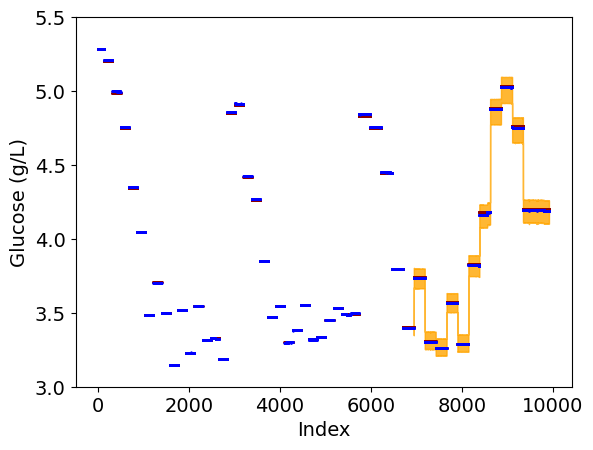


R2 train Score:  0.9973774958132133

R2 test Score:  0.9980952200536284

MSE train:  0.0010691967914851826

MSE test:  0.0006740813816108083


In [ ]:
"""Plotting"""

plt.xlabel("Index")
plt.ylabel("Glucose (g/L)")
#plt.title("Glucose Predictions against Index, Coverage = 95%")


plt.rcParams.update({'font.size': 14})

#Visualisation
plt.fill_between(test_index_shifted, LowerBound[:,0], UpperBound[:,0], color = 'orange', label = 'Prediction bands', alpha = 0.8)

#scatter plot of index vs glucose
plt.scatter(train_index, actuals[0:train_size], label='Actual values', color='darkred', s=1)
plt.scatter(train_index, train_predictions, label='Predictions', color='blue', s=0.5)

plt.scatter(test_index_shifted, actuals[train_size+1:len(X_df)], color='darkred', s=1)
plt.scatter(test_index_shifted, y_pred[:,0], color = 'blue', s=1)


# legend = plt.legend(loc="lower left")
# legend.get_frame().set_alpha(None)
# legend.legend_handles[0]._sizes = [30]
# legend.legend_handles[1]._sizes = [30]

ymin, ymax = 3, 5.5
plt.ylim(ymin, ymax)
plt.show()


R2_train = r2_score(y_train, train_predictions)
R2_test = r2_score(y_test, y_pred)

MSE_train = mean_squared_error(y_train, train_predictions)
MSE_test = mean_squared_error(y_test, y_pred)

print('\nR2 train Score: ', R2_train)
print('\nR2 test Score: ', R2_test)
print('\nMSE train: ', MSE_train)
print('\nMSE test: ', MSE_test)

In [ ]:
# Concatenating actuals
actuals_concat = actuals[train_size+1:len(X_df)]

# Calculating (Upperbound - Lowerbound)/actuals
cp_metric = ((UpperBound[:,0] - LowerBound[:,0]) / actuals_concat)*100

# Outputting minimum, maximum, and mean of the calculation
cp_metric_min = np.min(cp_metric)
cp_metric_max = np.max(cp_metric)
cp_metric_mean = np.mean(cp_metric)

print("Minimum:", round(cp_metric_min,3))
print("Maximum:", round(cp_metric_max,3))
print("Mean:", round(cp_metric_mean,3))

Minimum: 2.264
Maximum: 5.421
Mean: 3.679
